# Task 2 - False Color Image 

Date: 2024-11-23

Author: Jordan Sibley 

[Github Repository](https://github.com/jordancsibley/eds220-hwk4)

## Data

The data used to create the false color image of the Thomas fire is Landsat data and fire perimeter data. The Landsat Collection 2 Level-2 data is a simplifed collection of bands collected from the an atmosphereic satellite. The fire perimeter data is a subset of a CAL FIRE geodatabase that contains only the geometries for the Thomas Fire. 

In [5]:
# Import libraries 
import pandas as pd 
import numpy as np
import geopandas as gpd 
import os 
import rioxarray as rioxr
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

# Set environment variable
#os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

In [6]:
# File path to data on workbench 
fp = os.path.join("/courses/EDS220/data/hwk4_landsat_data/landsat8-2018-01-26-sb-simplified.nc")
landsat = rioxr.open_rasterio(fp)

In [7]:
# Explore landsat data 
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

In [8]:
# View data elements 
print('Height: ', landsat.rio.height)
print('Width: ', landsat.rio.width)
print('Size of dimensions: ', dict(landsat.sizes))
print('Spatial bounding box:')
print(landsat.rio.bounds(), '\n')
print('CRS: ', landsat.rio.crs)

Height:  731
Width:  870
Size of dimensions:  {'band': 1, 'x': 870, 'y': 731}
Spatial bounding box:
(121170.0, 3755160.0, 356070.0, 3952530.0) 

CRS:  EPSG:32611


The landsat data is an xarray that contains the band information. The dimensions are x and y and also band that just contains the interger 1.  The data variables of the xarray are the band types which are red, green, blue, near infrared (nir08), and the shortwave infrared (swir22). 

In [9]:
# Drop the `band` dimension of the data and remove dims of length 1 
landsat = landsat.squeeze().drop_vars('band')

# View altered landsat data 
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


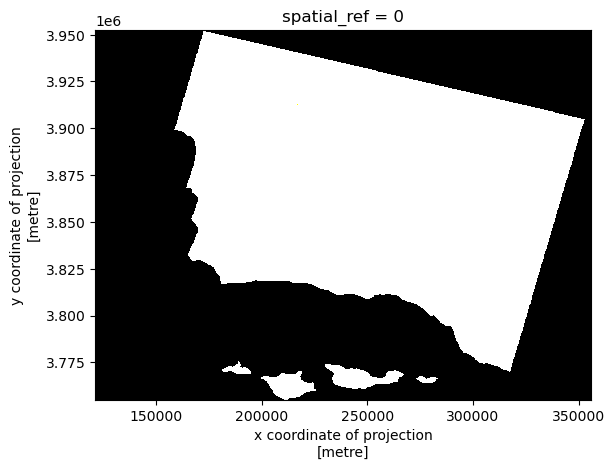

In [10]:
# Select bands to create RGB image 
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

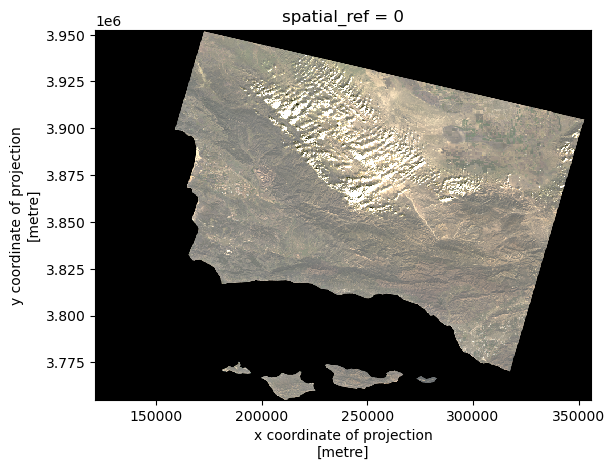

In [11]:
# Adjust scale to get true color image 
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)


In a markdown cell write a brief explanation comparing the ouputs for parts (a) and (b).

Creates a 2D image plot, where robust=True adjusts the color scale to exclude outliers (typically the top and bottom 2% of values), improving visualization.

In the 


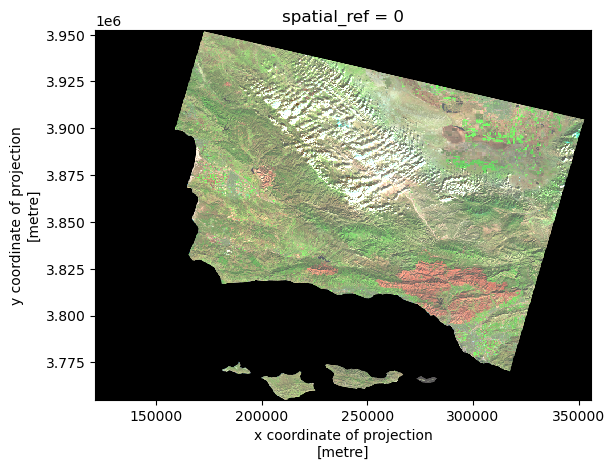

In [12]:
# Create false color image with short infrared, near infrared and red 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

In [13]:
# Read in Thomas fire perimeter data 
thomas = gpd.read_file('thomas-fire-boundary-file/thomas.shp')

# View dataset 
thomas

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,9,7,1,281791.0,CONT_DATE based on Inciweb,None,None,None,None,2010,"MULTIPOLYGON (((-13316089.016 4088553.040, -13..."


In [14]:
# Check if the CRSs match
landsat.rio.crs == thomas.crs

False

In [15]:
# Reproject thomas to landsat CRS
thomas = thomas.to_crs(landsat.rio.crs)

In [16]:
# Test that CRSs match
assert landsat.rio.crs == thomas.crs

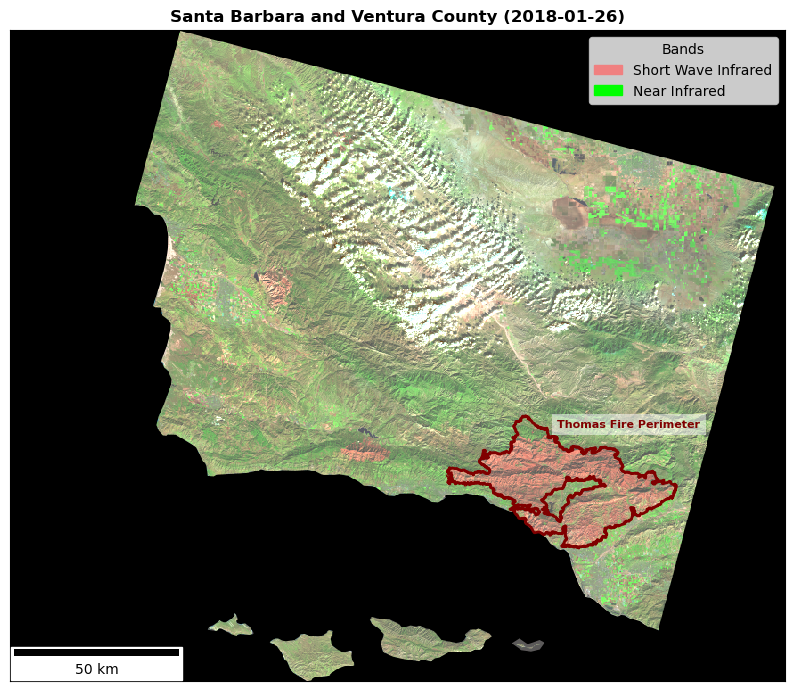

In [28]:
# Plot false color image with thomas fire boundary 
fig, ax= plt.subplots(figsize = (10, 10))

# False color landsat image 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True,
                                                           ax=ax
                                                          )

# Overlay Thomas Fire boundary
thomas.boundary.plot(ax=ax,
                     color = "maroon",
                     linewidth=2)

# Create custom legend for short wave and infrared 
swir_patch = mpatches.Patch(color='lightcoral', label='Short Wave Infrared')
nir_patch = mpatches.Patch(color='lime', label='Near Infrared')

# Set legend position 
ax.legend(handles=[swir_patch, nir_patch], loc='upper right', title='Bands')


# Set perimeter label 
ax.text(
    x=287070.0, y=3832030.0,  # Coordinates 
    s="Thomas Fire Perimeter",  # Label text
    color='maroon', fontsize=8, weight='bold',  
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none') 
    
)
# Set scale bar 
scalebar = ScaleBar(1, units='m', location='lower left', length_fraction=0.25, scale_loc='bottom', color='black')  
ax.add_artist(scalebar)


# Set title                                                           
ax.set_title("Santa Barbara and Ventura County (2018-01-26)", weight='bold')

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()

Write a figure description for the map including a brief explanation of how false color imagery is being used.

**Figure Description:** This map shows ... 


The short wave infrared (displayed in red) indicates the area burned. Newly burned land reflects strongly in SWIR bands, making them valuable for mapping fire damage. The near-infrared (displayed in green) indicates healthy vegetation (plants reflect NIR very strongly). The perimeter data comes from a CAL FIRE database. 